# Übungsaufgaben 5



## Aufgabe 1 (Bigramme mit pandas und scikit-learn)

Berechnen Sie auf dem Wahlverwandschaften-Text eine Stopwort-gefilterte Bigramm-Frequenzliste mit pandas-Dataframe und dem CountVectorizer von scikit-learn:

In [1]:
import pandas as pd
df = pd.read_csv('wahlverwandschaften.txt', sep = "\n", header=None) 
df.columns = ['lines']
df.head()

,lines
0,Die Wahlverwandtschaften
1,Ein Roman
2,von Johann Wolfgang von Goethe
3,Erster Teil
4,Erstes Kapitel


In [2]:
from nltk.corpus import stopwords
stop = stopwords.words('german')
stop[0:10]

['aber', 'alle', 'allem', 'allen', 'aller', 'alles', 'als', 'also', 'am', 'an']

In [3]:
from sklearn.feature_extraction.text import CountVectorizer
count_vectorizer = CountVectorizer(stop_words=stop, ngram_range=(2,2))

In [5]:
#CountVectorizer: convert a collection of text documents (here: lines) to a matrix of token (or n-gram) counts

# matrix of ngrams
ngrams = count_vectorizer.fit_transform(df['lines'])
ngrams

<1126x4004 sparse matrix of type '<class 'numpy.int64'>'
	with 4114 stored elements in Compressed Sparse Row format>

In [14]:
# list of ngrams
vocab = count_vectorizer.vocabulary_
list(vocab)[0:10]

['johann wolfgang',
 'wolfgang goethe',
 'erster teil',
 'erstes kapitel',
 'eduard nennen',
 'nennen reichen',
 'reichen baron',
 'baron besten',
 'besten mannesalter',
 'mannesalter eduard']

In [18]:
# count frequency of ngrams
count_values = ngrams.toarray().sum(axis=0) #sum cols
count_values

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [15]:
# create dataframe
df_ngram = pd.DataFrame(sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True)
            ).rename(columns={0: 'frequency', 1:'bigram'})
df_ngram

,frequency,bigram
0,17,versetzte charlotte
1,16,sagte charlotte
2,13,sagte eduard
3,9,versetzte eduard
4,6,versetzte hauptmann
...,...,...
3999,1,abende frühsten
4000,1,abende flöte
4001,1,abend veranlaßte
4002,1,abend eduard


# Aufgabe 2 (Topic Modeling mit scikit-learn und pandas)

Lesen Sie den Wahlverwandschaften-Text **absatzweise** ein und speichern die Absätze in einem pandas-Dataframe.

In [5]:
import warnings
warnings.filterwarnings("ignore")

In [6]:
text = open('wahlverwandschaften.txt').read().lower()

import re
paragraphs = re.split(r'\n\n+', text)
paragraphs[0:7]

['die wahlverwandtschaften',
 'ein roman',
 'von johann wolfgang von goethe',
 'erster teil',
 'erstes kapitel',
 'eduard—so nennen wir einen reichen baron im besten mannesalter—eduard\nhatte in seiner baumschule die schönste stunde eines aprilnachmittags\nzugebracht, um frisch erhaltene pfropfreiser auf junge stämme zu\nbringen. sein geschäft war eben vollendet; er legte die gerätschaften\nin das futteral zusammen und betrachtete seine arbeit mit vergnügen,\nals der gärtner hinzutrat und sich an dem teilnehmenden fleiße des\nherrn ergetzte.',
 '„hast du meine frau nicht gesehen?“ fragte eduard, indem er sich\nweiterzugehen anschickte.']

In [7]:
import pandas as pd
df = pd.DataFrame(paragraphs)
df.columns = ['paragraphs']
df

,paragraphs
0,die wahlverwandtschaften
1,ein roman
2,von johann wolfgang von goethe
3,erster teil
4,erstes kapitel
...,...
168,"„ich leugne nicht“, sagte eduard, „daß die sel..."
169,"„wenn sie glauben, daß es nicht pedantisch aus..."
170,„nun denn!“ fiel eduard ein; „bis wir alles di...
171,„gut!“ versetzte charlotte. „wenn auch das bei...


### Aufgabe 2a: Grid Search  

Verwenden Sie die Grid-Search-Funktionalität von scikit-learn (https://scikit-learn.org/stable/modules/grid_search.html#grid-search) 
um für die Absätze des Textes 
die optimale Topic-Anzahl 
über LDA (`LatentDirichletAllocation`)
herauszufinden. 

- Wenden Sie den `TfidfVectorizer` auf die Absatzsammlung an (`X`).
- Verwenden Sie untenstehenden Code, um für verschiedene Werte des `n_components`-Parameters (Topic-Anzahl) den `best_estimator_` zu berechnen.
- Verwenden Sie anschließend die `display_topics`-Funktion von oben (Thema 4), um die Top-Keywords für das beste Modell auszugeben.



In [8]:
#data lda
corpus = df['paragraphs']

from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words=stop)
X = tfidf_vectorizer.fit_transform(corpus) #X = vectors
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print(X.shape)

(173, 2806)


In [9]:
#Code: https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/#20howtoclusterdocumentsthatsharesimilartopicsandplot
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV

# Define Search Param
search_params = {'n_components': [3, 5, 7, 10, 15, 20], 'learning_decay': [.5, .7, .9]}

##n_components-Grid: Number of Topics

##learning_decay, see: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html:
#float, default=0.7:
#It is a parameter that control learning rate in the online learning method. 
#The value should be set between (0.5, 1.0] to guarantee asymptotic convergence. 
#When the value is 0.0 and batch_size is n_samples, the update method is same as batch learning. 
#In the literature, this is called kappa.


# Init the Model
lda = LatentDirichletAllocation(random_state=0)

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(X)

GridSearchCV(cv=None, error_score='raise',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_components=10, n_jobs=1,
             n_topics=None, perp_tol=0.1, random_state=0,
             topic_word_prior=None, total_samples=1000000.0, verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_components': [3, 5, 7, 10, 15, 20], 'learning_decay': [0.5, 0.7, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [10]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(X))

Best Model's Params:  {'learning_decay': 0.5, 'n_components': 3}
Best Log Likelihood Score:  -3074.8505025062054
Model Perplexity:  14466.436797311793


In [11]:
best_lda_model

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.5, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_components=3, n_jobs=1,
             n_topics=None, perp_tol=0.1, random_state=0,
             topic_word_prior=None, total_samples=1000000.0, verbose=0)

In [12]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 20

In [13]:
display_topics(best_lda_model, tfidf_feature_names, no_top_words)

Topic 0:
sagte charlotte eduard schon frage lassen vereinigen muß versetzte wesen bald wohl ganz beistimmend wasser verhältnis gern wäre fragte wissen
Topic 1:
sagte eduard charlotte hauptmann chemiker beschreiben fall versetzte welt viertes völlig immer erst erwiderte versichert beseitelegte aufmerksamkeit chemischen ganzen arbeit
Topic 2:
kapitel versetzte charlotte fünftes hauptmann fiel öl rief genug verwandtschaften verlassen gleich wasser mehr verbinden leider laugensalz eduard wer wort


### Aufgabe 2b: Dominante Topics

Verwenden Sie untenstehenden Code (vgl. https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/#14howtoseethedominanttopicineachdocument), 
um die Dokument-Topic-Matrix in einem Dataframe abzuspeichern 
und das dominante Topic für jedes Dokument (hier: Absatz) zu bestimmen.

In [14]:
best_lda_model.n_components

3

In [15]:
data = df['paragraphs']
data_vectorized = X

In [16]:
#Code: https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/#14howtoseethedominanttopicineachdocument

# Create Document - Topic Matrix
lda_output = best_lda_model.transform(data_vectorized)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

# index names
#docnames = ["Doc" + str(i) for i in range(len(data))]
docnames = [str(i) for i in data]

In [17]:
import numpy as np

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

In [18]:
# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,dominant_topic
die wahlverwandtschaften,0.180000,0.630000,0.180000,1
ein roman,0.660000,0.170000,0.170000,0
von johann wolfgang von goethe,0.120000,0.130000,0.750000,2
erster teil,0.140000,0.150000,0.710000,2
erstes kapitel,0.140000,0.140000,0.720000,2
"eduard—so nennen wir einen reichen baron im besten mannesalter—eduard hatte in seiner baumschule die schönste stunde eines aprilnachmittags zugebracht, um frisch erhaltene pfropfreiser auf junge stämme zu bringen. sein geschäft war eben vollendet; er legte die gerätschaften in das futteral zusammen und betrachtete seine arbeit mit vergnügen, als der gärtner hinzutrat und sich an dem teilnehmenden fleiße des herrn ergetzte.",0.890000,0.060000,0.060000,0
"„hast du meine frau nicht gesehen?“ fragte eduard, indem er sich weiterzugehen anschickte.",0.120000,0.780000,0.100000,1
"„drüben in den neuen anlagen“, versetzte der gärtner. „die mooshütte wird heute fertig, die sie an der felswand, dem schlosse gegenüber, gebaut hat. alles ist recht schön geworden und muß euer gnaden gefallen. man hat einen vortrefflichen anblick: unten das dorf, ein wenig rechter hand die kirche, über deren turmspitze man fast hinwegsieht, gegenüber das schloß und die gärten“.",0.060000,0.060000,0.880000,2
"„ganz recht“, versetzte eduard; „einige schritte von hier konnte ich die leute arbeiten sehen“.",0.810000,0.090000,0.090000,0
"„dann“, fuhr der gärtner fort, „öffnet sich rechts das tal, und man sieht über die reichen baumwiesen in eine heitere ferne. der stieg die felsen hinauf ist gar hübsch angelegt. die gnädige frau versteht es; man arbeitet unter ihr mit vergnügen“.",0.080000,0.080000,0.850000,2


### Aufgabe 2c: Clustering  der Topics

Verwenden Sie den KMeans-Algorithmus, 
um ähnliche Themen zu clustern
und das Ergebnis zu plotten.

Sie können sich dabei an untenstehendem Code orientieren (vgl. https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/#20howtoclusterdocumentsthatsharesimilartopicsandplot).


In [19]:
lda_output[0:5]

array([[0.18303698, 0.63311213, 0.18385089],
       [0.661269  , 0.16935577, 0.16937523],
       [0.12484935, 0.12512748, 0.75002317],
       [0.14108025, 0.1494746 , 0.70944515],
       [0.1397106 , 0.14082282, 0.71946659]])

In [20]:
best_lda_model.n_components

3

In [21]:
#Code: https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/#20howtoclusterdocumentsthatsharesimilartopicsandplot

# Construct the k-means clusters
from sklearn.cluster import KMeans
clusters = KMeans(n_clusters=best_lda_model.n_components, random_state=0).fit_predict(lda_output)

## Dimensionsreduktion:

# Build the Singular Value Decomposition(SVD) model
from sklearn.decomposition import TruncatedSVD

svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_output_svd = svd_model.fit_transform(lda_output)

# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]

# Weights for the 15 columns of lda_output, for each component
print("Component's weights: \n", np.round(svd_model.components_, 2))

# Percentage of total information in 'lda_output' explained by the two components
print("Perc of Variance Explained: \n", np.round(svd_model.explained_variance_ratio_, 2))

Component's weights: 
 [[ 0.82  0.42  0.39]
 [-0.57  0.68  0.46]]
Perc of Variance Explained: 
 [0.06 0.49]


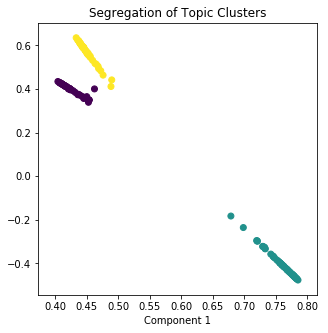

In [22]:
# Plot
import matplotlib.pyplot as plt
#import pandas as pd
%matplotlib inline

plt.figure(figsize=(5, 5))
plt.scatter(x, y, c=clusters)
plt.xlabel('Component 2')
plt.xlabel('Component 1')
plt.title("Segregation of Topic Clusters", )

# Aufgabe 3 (Dokumentenklassifikation mit scikit-learn)


### Aufgabe 3a: SVM-Klassifikator-Pipeline

Trainieren und testen Sie - analog zu Thema 3 der Vorlesung einer tfidf-Keyword-basierten Klassifikation mit Naive Bayes Modell - einen SVM-Klassifikator mit dem `20newsgroups`-Korpus von scikit-learn in einer Pipeline.

In [23]:
#import data
from sklearn.datasets import fetch_20newsgroups
categories = ['alt.atheism', 'soc.religion.christian','comp.graphics', 'sci.med']
twenty_train = fetch_20newsgroups(subset='train', categories=categories, shuffle=True, random_state=42)

In [24]:
#import classifier
from sklearn import svm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

#Building a pipeline with SVM-classifier:
from sklearn.pipeline import Pipeline
text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', svm.LinearSVC()),
    ])

In [25]:
text_clf.fit(twenty_train.data, twenty_train.target)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...ax_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])

In [26]:
#Evaluation of the performance on the test set
twenty_test = fetch_20newsgroups(subset='test', categories=categories, shuffle=True, random_state=42)
docs_test = twenty_test.data
predicted = text_clf.predict(docs_test)
np.mean(predicted == twenty_test.target)

0.9214380825565912

### Aufgabe 3b: Prediction

Verwenden Sie das trainierte Klassifikator-Modell anschließend für die Vorhersage der Genre-Klassen neuer Texte/Sätze.

In [27]:
#predict
docs_new = ['God is love', 'OpenGL on the GPU is fast']
#keine Vektorisierung nötig mit Pipeline!

In [28]:
#from above:
text_clf

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...ax_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])

In [29]:
predicted = text_clf.predict(docs_new)

for doc, category in zip(docs_new, predicted):
    print('%r => %s' % (doc, twenty_train.target_names[category]))

'God is love' => soc.religion.christian
'OpenGL on the GPU is fast' => comp.graphics
